## 0. import 모음

In [24]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# 1. 구글마운트

In [2]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# 2. 데이터셋 만들기

## 데이터 위치로 이동

In [3]:
%cd '/gdrive/MyDrive/EM_LSTM/data'

/gdrive/MyDrive/EM_LSTM/data


## file list 가져오기

In [4]:
path_dir = './'
file_list = os.listdir(path_dir)

## file 불러오기

In [5]:
em_x = []
em_y = []
for i in file_list :
  tempstr = './'+i
  em_x.append(np.array(pd.read_csv(tempstr)))
  #파일을 불러오면서 맨 앞 글자를 가져와 y 로 씀
  em_y.append(i[0])

In [6]:
# 데이터를 다시 불러와야 하거나 로우데이터로 뭔가 확인을 해야할 수 있으므로 em_x 는 그대로 두고 em_x2 생성
# 하는 김에 np.array로 해서 shape 도 봄.
em_x2 = np.array(em_x)
em_x2[0].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


(202, 7)

## y 값 인코딩

In [7]:
# 불러온 파일 갯수와 같은지 한번 체크
print(len(em_y))

42


In [8]:
reshape_ha = list(em_y)

In [9]:
# 위에 확인된 enc 가 a, b, c 순서가 아닌 경우 실행하여 순서를 맞춰줌.
# dec 도 세팅해야할텐데..
enc = {'a': 0, 'b': 1, 'c': 2}

- 인코딩 잘 됐는지 확인

In [10]:
lst_e = [enc[i] for i in reshape_ha]

- em_x 와 마찬가지로 em_y 보존을 위해 em_y2 생성

In [11]:
em_y2 = lst_e

# EDA

# 학습형태로 만들어주기
- 100개 씩 끊어서 LSTM 에서 학습할 수 있게 만들어 줌.

In [12]:
# 뒤에서 끊어주기
# for 문을 통해 frames 단위로 학습을 하는 부분임.
npx = []
npy = []
frames = 100
for fileidx in range(0,len(em_x2)):
  # 파일당 최대 갯수를 지정
  # endpoint = int (em_x2[fileidx].shape[0]) 
  endpoint = 50
  for i in range(1,endpoint,1):
    i = (i +frames)* -1
    idx = i+100
    npx.append(np.array(em_x2[fileidx][i:idx]))
    npy.append(np.array(em_y2[fileidx]))
npx = np.array(npx)
npy = np.array(npy)
print(npx.shape, npy.shape)

(2058, 100, 7) (2058,)


## y 값 원핫 인코딩

In [13]:
ohe=np.eye( len(enc.keys() ))

In [14]:
temp_elst = [ohe[i] for i in npy]

In [15]:
npy = np.array(temp_elst)

In [16]:
npy.shape

(2058, 3)

## 정답 분포 확인

In [17]:
pdy = pd.DataFrame(npy)
pdy.value_counts()

0    1    2  
1.0  0.0  0.0    686
0.0  1.0  0.0    686
     0.0  1.0    686
dtype: int64

## 셔플링

In [18]:
X_train, X_test, y_train, y_test = train_test_split(npx, npy, 
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    random_state=1004)

In [19]:
print (len(X_train),len(X_test),len(y_train),len(y_test))

1440 618 1440 618


# 4. LSTM 모델 만들기

## 모델 구성
- 들어오는 데이터의 약 2배 이상의 히든레이어 생성
- y 값에 맞춰 3 개를 softmax 형태로 아웃풋 지정

In [20]:

K.clear_session()
model = Sequential() # Sequeatial Model 
model.add(LSTM(200, input_shape=( frames,  em_x2[0].shape[1]),activation='sigmoid')) # (timestep, feature) 
model.add(Dense(3,activation='softmax')) # output = 1
# admax = keras.optimizers.Adamax(learning_rate=0.12, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
# model.compile(optimizer=admax, loss='mse')
#admax = keras.optimizers.Adamax(learning_rate=0.12, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss='mse', optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               166400    
_________________________________________________________________
dense (Dense)                (None, 3)                 603       
Total params: 167,003
Trainable params: 167,003
Non-trainable params: 0
_________________________________________________________________


In [21]:
# X_train, X_test, y_train, y_test
history = model.fit(X_train, y_train, batch_size=30, epochs=100, verbose=1, validation_data=(X_test, y_test))

Epoch 1/100
48/48 [==============================] - 11s 206ms/step - loss: 0.2254 - val_loss: 0.2261
Epoch 2/100
48/48 [==============================] - 9s 190ms/step - loss: 0.2244 - val_loss: 0.2233
Epoch 3/100
48/48 [==============================] - 9s 188ms/step - loss: 0.2243 - val_loss: 0.2220
Epoch 4/100
48/48 [==============================] - 9s 186ms/step - loss: 0.2232 - val_loss: 0.2286
Epoch 5/100
48/48 [==============================] - 9s 190ms/step - loss: 0.2227 - val_loss: 0.2258
Epoch 6/100
48/48 [==============================] - 9s 190ms/step - loss: 0.2236 - val_loss: 0.2215
Epoch 7/100
48/48 [==============================] - 9s 187ms/step - loss: 0.2224 - val_loss: 0.2252
Epoch 8/100
48/48 [==============================] - 9s 185ms/step - loss: 0.2238 - val_loss: 0.2215
Epoch 9/100
48/48 [==============================] - 9s 190ms/step - loss: 0.2214 - val_loss: 0.2220
Epoch 10/100
48/48 [==============================] - 9s 193ms/step - loss: 0.2209 - val_l

In [22]:
%cd '/gdrive/MyDrive/EM_LSTM'
!pwd
model.save('./emo_reverse.h5')

/gdrive/MyDrive/EM_LSTM
/gdrive/MyDrive/EM_LSTM


# 평가

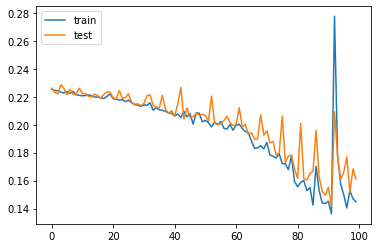

In [26]:
# plot history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [27]:
y_true = np.array(y_test)
x_scaled = np.array(X_test)
y_pred = model.predict(x_scaled)

In [28]:
y_pred2 = np.argmax(y_pred, axis=1)
y_true2 = np.argmax(y_true, axis=1)

## Confusion Matrix

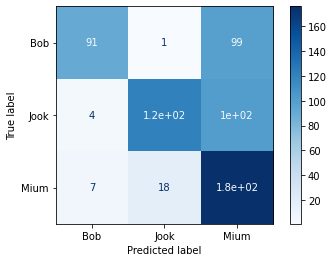

In [29]:
labels = ["Bob", "Jook", "Mium"]

cm = confusion_matrix(y_true2, y_pred2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## Accuracy

In [30]:
labels = y_true2	# 실제 labels
guesses = y_pred2	# 에측된 결과

print(accuracy_score(labels, guesses))

0.627831715210356
